In [1]:
import os
import sys

# --- FIX THE IMPORT ERROR ---
# Get the current notebook's directory
notebook_dir = os.getcwd() 
# Go one level up to get the project root
project_root = os.path.dirname(notebook_dir)

# Add the project root to the Python path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

# Now the imports should work
try:
    from src.dinov2_backbone import DinoV2Backbone
    from src.dinogaze import (build_saliency_network, build_scanpath_network, build_fixation_selection_network)
    from src.modules import DeepGazeIII
    from src.training import _extract_model_state_dict_from_checkpoint
    print("Successfully imported project modules.")
except ImportError as e:
    print(f"FATAL: Still could not import modules. Please check your project structure.")
    print(f"Current sys.path: {sys.path}")
    print(f"Error: {e}")

# Other necessary imports
import argparse
import logging
from pathlib import Path
import yaml
from types import SimpleNamespace
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pysaliency

import random
import pysaliency
import pysaliency.external_datasets.mit
from pysaliency.dataset_config import validation_split

# Set up a basic logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
_logger = logging.getLogger("visualize_saliency_notebook")

Added project root to sys.path: /home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation


/home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/.pixi/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully imported project modules.


/home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/.pixi/envs/default/lib/python3.11/site-packages/pysaliency/external_models/matlab_models.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


In [2]:
# --- USER CONFIGURATION ---
# This cell now loads the dataset, sets a seed, and randomly picks an image.

# 1. Path to the YAML config file
config_file_path = os.path.join(project_root, 'configs/mit_dinogaze_spade_dynamic_embedding_sam_64.yaml')

# 2. Path to the trained model checkpoint
checkpoint_path = os.path.join(project_root, '/home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/experiments/train_dinogaze_simple_test/mit_spatial/crossval-10-0/step-0008.pth')

# 3. Path to save the output file
output_path = os.path.join(project_root, 'output/saliency_visualization.png')

# 4. Random seed for reproducibility. Change this number to get a different random image.
random_seed = 42

# 5. Device to use
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- End of Main Configuration ---


# --- Load Config and Dataset to Select an Image ---
_logger.info("--- Loading dataset to select a random image ---")
try:
    with open(config_file_path, 'r') as f:
        config_dict = yaml.safe_load(f)
    
    # Get dataset directory and fold from the config
    dataset_root_dir = config_dict.get('dataset_dir', './data/pysaliency_datasets')
    fold = config_dict.get('fold', 0)
    
    _logger.info(f"Loading MIT1003 dataset from: {dataset_root_dir}")
    _logger.info(f"Using validation split for fold: {fold}")

    # Load the original MIT1003 dataset (pysaliency will download it if needed)
    mit_stimuli_orig, mit_fixations_orig = pysaliency.external_datasets.mit.get_mit1003_with_initial_fixation(
        location=os.path.join(project_root, dataset_root_dir),
        replace_initial_invalid_fixations=True
    )
    
    # Get the validation split for the specified fold
    val_stim, _ = validation_split(mit_stimuli_orig, mit_fixations_orig, crossval_folds=10, fold_no=fold)
    
    # Get the list of original (pre-resize) image filenames for the validation set
    validation_filenames = val_stim.filenames
    
    # Set the seed and choose a random image
    random.seed(random_seed)
    image_path = random.choice(validation_filenames)
    
    _logger.info(f"Random seed set to: {random_seed}")
    _logger.info(f"Randomly selected image from validation set (fold {fold}): {os.path.basename(image_path)}")

except Exception as e:
    _logger.error(f"Failed to load dataset or select an image: {e}")
    _logger.error("Please ensure 'dataset_dir' and 'fold' are correct in your YAML file.")
    # As a fallback, you can manually set image_path here if loading fails
    # image_path = '/path/to/some/image.jpg'


# --- Final check of all paths ---
if not os.path.exists(config_file_path): _logger.error(f"Config file not found: {config_file_path}")
if not os.path.exists(checkpoint_path): _logger.error(f"Checkpoint file not found: {checkpoint_path}")
if 'image_path' not in locals() or not os.path.exists(image_path):
    _logger.error(f"Input image path was not set or is invalid: {image_path if 'image_path' in locals() else 'Not Set'}")

2025-07-22 17:47:01,389 - INFO - --- Loading dataset to select a random image ---
2025-07-22 17:47:01,398 - INFO - Loading MIT1003 dataset from: ./data/pysaliency_datasets
2025-07-22 17:47:01,399 - INFO - Using validation split for fold: 0
2025-07-22 17:47:03,637 - INFO - Random seed set to: 42
2025-07-22 17:47:03,637 - INFO - Randomly selected image from validation set (fold 0): i1335933891.jpeg


Using random shuffles for crossvalidation


2025-07-22 18:06:50,500 - INFO - Using device: cuda
2025-07-22 18:06:50,502 - INFO - Building model with architecture derived from visualization script...
Using cache found in /home/mmorello/.cache/torch/hub/facebookresearch_dinov2_main
2025-07-22 18:06:51,004 - INFO - using MLP layer as FFN
2025-07-22 18:06:57,012 - INFO - Loading checkpoint: /home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/experiments/train_dinogaze_simple_test/mit_spatial/crossval-10-0/step-0008.pth
2025-07-22 18:06:57,605 - INFO - Model weights loaded successfully.
2025-07-22 18:06:57,605 - INFO - Processing image: /home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/./data/pysaliency_datasets/MIT1003_initial_fix_consistent/stimuli/i1335933891.jpeg
2025-07-22 18:06:57,616 - INFO - Generating saliency map...
2025-07-22 18:06:58,172 - INFO - Saliency map generated successfully.
2025-07-22 18:06:58,173 - INFO - Saving visualization to: /home/mmorello/Decoding_Neural_Dynami

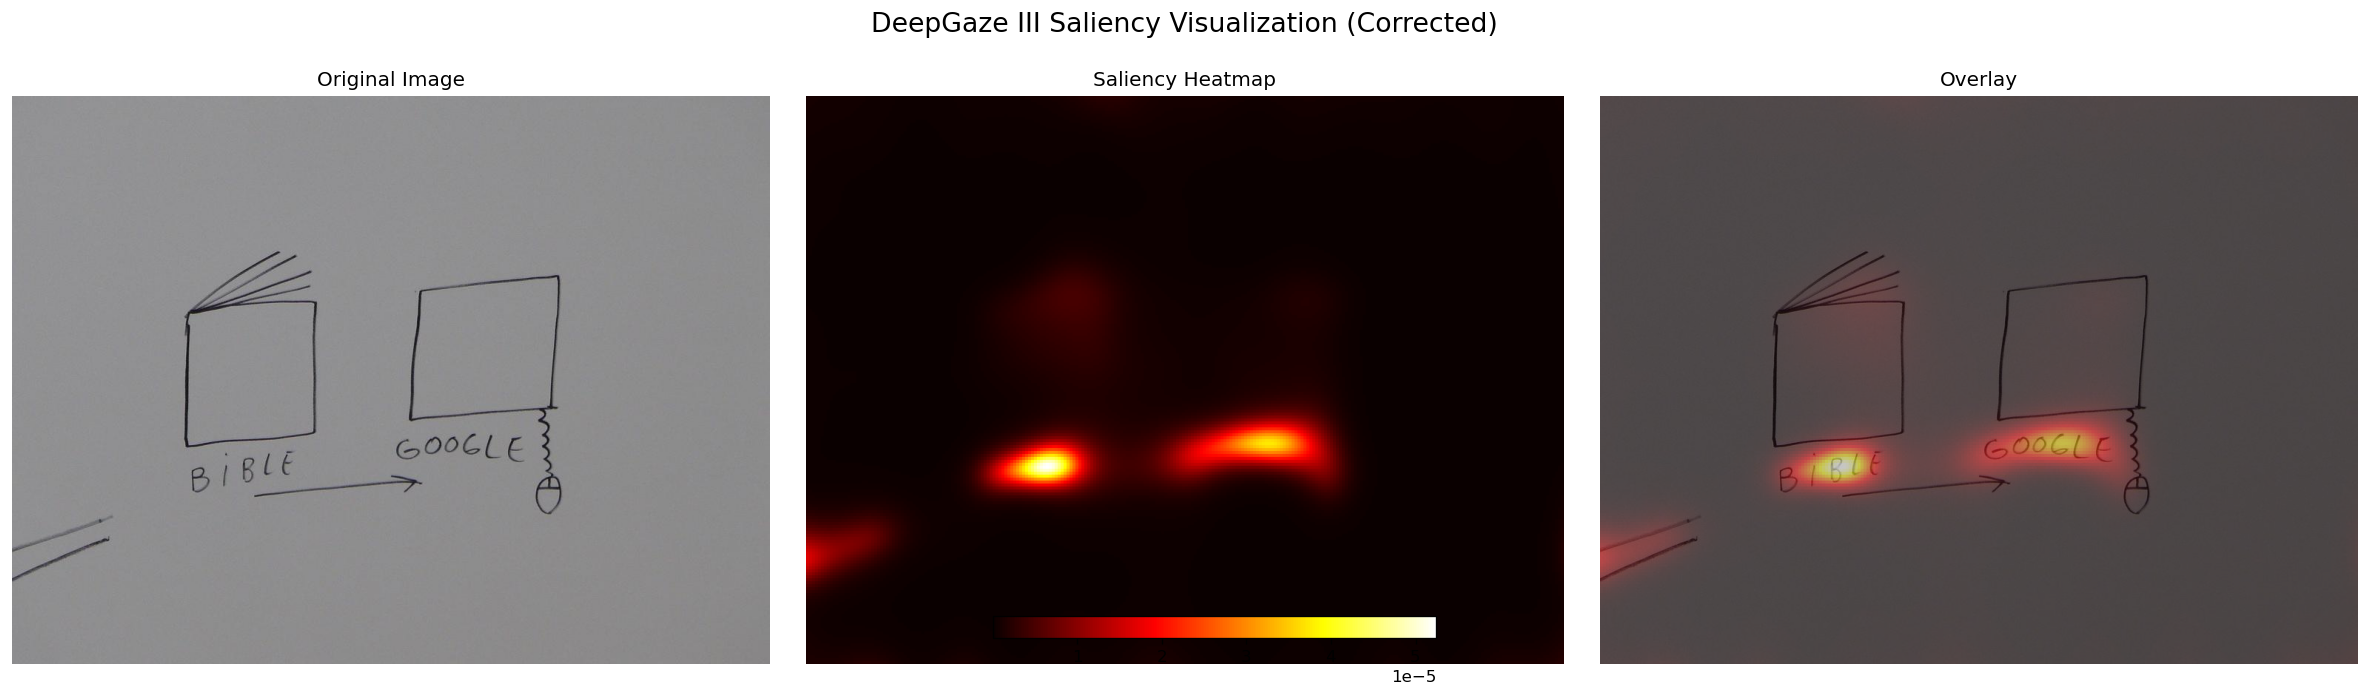

2025-07-22 18:07:00,044 - INFO - Visualization complete.


In [16]:
# --- MAIN EXECUTION LOGIC ---
device = torch.device(device_name)
_logger.info(f"Using device: {device}")

# 1. --- Build the Model with the CORRECT Architecture ---
_logger.info("Building model with architecture derived from visualization script...")
backbone = DinoV2Backbone(
    layers=[-3, -2, -1],
    model_name='dinov2_vitl14', # Assuming this from your checkpoint name
    freeze=True
)
C_in = len(backbone.layers) * backbone.num_channels

model = DeepGazeIII(
    features=backbone,
    saliency_network=build_saliency_network(C_in), # We don't need add_sa_head for this one
    scanpath_network=None,
    fixation_selection_network=build_fixation_selection_network(0),
    # fixation_selection_network=FixationSelectionIdentity(), # This was commented out in
    downsample=1,
    readout_factor=7, # From your old script
    saliency_map_factor=4,
    included_fixations=[]
).to(device)

# 2. --- Load the Model Weights ---
_logger.info(f"Loading checkpoint: {checkpoint_path}")
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

# Load the entire checkpoint file first. It's not just a state_dict.
checkpoint_data = torch.load(checkpoint_path, map_location=device, weights_only=False)

# The model weights are under the 'model' key.
if 'model' in checkpoint_data:
    model_state_dict = checkpoint_data['model']
else:
    # If no 'model' key, assume the whole file is the state_dict
    model_state_dict = checkpoint_data
    _logger.warning("Checkpoint does not contain a 'model' key. Assuming the file is a raw state_dict.")

# Clean the keys ('module.' prefix) if they exist
cleaned_state_dict = {k.replace('module.', ''): v for k, v in model_state_dict.items()}

# Load with strict=False to ignore any layers that might not be in the checkpoint
# (e.g., if you saved only the saliency head)
model.load_state_dict(cleaned_state_dict, strict=False)
model.eval()
_logger.info("Model weights loaded successfully.")


# 3. --- Preprocess Image ---
_logger.info(f"Processing image: {image_path}")
original_image = Image.open(image_path).convert('RGB')
# The DINOv2 backbone expects a uint8 tensor [0, 255]
img_np = np.array(original_image)
image_tensor = torch.from_numpy(img_np.transpose(2, 0, 1)).unsqueeze(0).to(device)


# 4. --- Generate Saliency Map ---
_logger.info("Generating saliency map...")
with torch.no_grad():
    # Create a dummy centerbias tensor of the correct size
    _, _, h, w = image_tensor.shape
    centerbias = torch.zeros((1, h, w), device=device)
    
    # The model's forward pass
    log_density = model(image_tensor, centerbias)
    saliency_map_tensor = torch.exp(log_density)
    
saliency_map_np = saliency_map_tensor.squeeze().cpu().numpy()
_logger.info("Saliency map generated successfully.")
if saliency_map_np.sum() < 1e-6:
     _logger.error("WARNING: Saliency map is all zeros! There might still be an issue.")


# 5. --- Visualize and Save ---
_logger.info(f"Saving visualization to: {output_path}")
saliency_resized_np = np.array(Image.fromarray(saliency_map_np).resize(original_image.size, Image.Resampling.BILINEAR))

fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=120)
fig.suptitle('DeepGaze III Saliency Visualization (Corrected)', fontsize=16)

axes[0].imshow(original_image); axes[0].set_title('Original Image'); axes[0].axis('off')
im = axes[1].imshow(saliency_resized_np, cmap='hot'); axes[1].set_title('Saliency Heatmap'); axes[1].axis('off')
axes[2].imshow(original_image); axes[2].imshow(saliency_resized_np, cmap='hot', alpha=0.5); axes[2].set_title('Overlay'); axes[2].axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.04, pad=0.05)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path)
plt.show()
plt.close()
_logger.info("Visualization complete.")